# Import libraries and dataset

Credit: Pluralsight (Janini Ravi)

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

1.10.1


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 2080 Super


In [4]:
# Set mean and standard deviation for normalisation as per Pytorch documentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
# Define the transformations - resizing, cropping, flipping, converting to tensors and normalising
train_transform = transforms.Compose([
                                transforms.Resize(256), # image should be at least 224 after resize
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(256),  # as this is the test set there is no randomisation
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [6]:
# Unzip all files in flowers dataset
import zipfile
zip = zipfile.ZipFile('Datasets/flowers_.zip')
zip.extractall('Datasets')

In [7]:
# Create directory for images and dictionary for the training and test data
data_dir = 'datasets/flowers_'
image_datasets ={}

In [8]:
# Transform the training and test sets - image folder allows images from local folder to be transformed
image_datasets['train']= datasets.ImageFolder(data_dir + '/train', train_transform)
image_datasets['test']= datasets.ImageFolder(data_dir + '/test', test_transform)

print("Training data - %d" %  len(image_datasets['train']))
print("Test data - %d" %  len(image_datasets['test']))

Training data - 3027
Test data - 1296


In [51]:
# Get the flower classes
class_names = image_datasets['train'].classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [10]:
# Information about the images
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3027
     Root location: datasets/flowers_/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1296
     Root location: datasets/flowers_/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [11]:
# Set the dataloaders with batch size of 8

dataloaders ={}

dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4)

dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                  batch_size=8,
                                                  shuffle=True,
                                                  num_workers=4)

In [12]:
# Get one batch from the training set
inputs, labels = next(iter(dataloaders['train']))
print(inputs.shape)   # the batch size of 8, three channels, each image is 224 by 224 pixels (minimum size of cropped images)
print(labels)  # the labels for each image

torch.Size([8, 3, 224, 224])
tensor([1, 2, 1, 4, 4, 2, 3, 1])


In [13]:
# Make a grid to view in matplotlib
inp = torchvision.utils.make_grid(inputs)
print(inp.shape)
print(inp.max())  # the max value of R, G or B is 2.64

torch.Size([3, 228, 1810])
tensor(2.6400)


In [14]:
# Clio the value of input as Matplotlib requires the RGB values to be within a range of 0 to 1
np.clip(inp, 0, 1).max()

tensor(1.)

In [15]:
# Reshape the image for matplotlib with height, width and then number of channels at the third value
trans = inp.numpy().transpose((1, 2, 0))
trans.shape

(228, 1810, 3)

In [16]:
# Function to show images
def img_show(inp, title=None):
    
    inp = std * trans + mean # normalise
    inp = np.clip(inp, 0, 1)  # clip
    
    plt.figure(figsize=(16,4))
    plt.axis('off')
    plt.imshow(inp) # show the image
    
    if title is not None:
        plt.title(title)

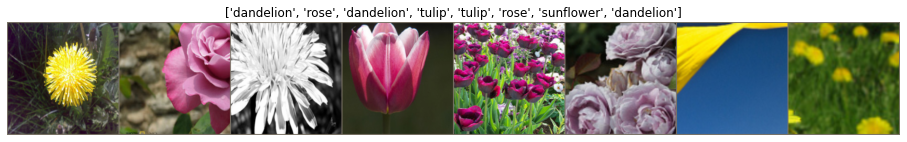

In [17]:
# Show the images with the labels for each image
img_show(inp, title=[flowers[x] for x in labels])

# Load ResNet pretrained model

In [18]:
model = models.resnet18(pretrained=True)

In [19]:
# Define a linear layer for output which replaces the pretrained model linear layer

num_ftrs = model.fc.in_features  # get the number of features needed to pass into the linear layer from the model
num_ftrs

512

In [20]:
import torch.nn as nn  #neural network model
import torch.optim as optim # optimizer

In [21]:
# Define the linear layer with the number of features 512 and the number of flower output classes which is five
model.fc = nn.Linear(num_ftrs, 5)

In [22]:
# Set criterion and optimizer

criterion = nn.CrossEntropyLoss() # define loss function

optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9) # define optimizer with stochastic gradient descent and 
                                                                # learning rate momentum parameter to accelerate learning

In [23]:
# Set a learning rate scheduler to adjust the learning rate as the model converges

from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.1) # reduce the learning rate every 7 epochs by 0.1

In [24]:
# Function to calculate the loss at each epoch for training and test
def calculate_accuracy(phase, running_loss, running_corrects):

    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])

    print('{} Loss: {:.4f} Acc: {:.4f}'.format( phase, epoch_loss, epoch_acc))
    
    return (epoch_loss, epoch_acc)

In [25]:
# Function to apply to each epoch in the training phase

def phase_train(model, criterion, optimizer, scheduler):
    
    model.train()    # sets the pre-trained model into training mode (for pre-trained models only)
    running_loss = 0.0   # records the loss at each iteration
    running_corrects = 0   # records the number of correct predictions to get the accuracy of the model
    
    
    for inputs, labels in dataloaders['train']:

        optimizer.zero_grad() # reset gradient to zero
        
        with torch.set_grad_enabled(True):  # enable Autograd
            outputs = model(inputs)          # probabilities for each label for the batch
            _, preds = torch.max(outputs, 1)   # get the index of the highest probability label for each image in the batch
            loss = criterion(outputs, labels)  # calculated the loss
            
            loss.backward()  # run the backward pass to get the gradients
            optimizer.step() # update the model parameters
                                
        running_loss += loss.item() * inputs.size(0)  # track running loss
        running_corrects += torch.sum(preds == labels.data)
    
    scheduler.step()  # sets up the scheduler to reduce the learning rate at each step
            
    calculate_accuracy('train', running_loss, running_corrects) # get current accuracy

In [26]:
# Get the best accuracy on test data
import copy
best_acc = 0.0

def phase_test(model, criterion, optimizer):
    
    model.eval()  # set the pre-trained model to evaluation mode (pre-trained models only)
    running_loss = 0.0 # track the loss for each iteration
    running_corrects = 0  # tracks the number of correct predictions to determine accuracy
    global best_acc  # model weights with best accuracy on test data
    
    for inputs, labels in dataloaders['test']:

        optimizer.zero_grad() # zero out gradients
        
        with torch.no_grad():  # do not use Autograd
            outputs = model(inputs)  # list of probabilities
            _, preds = torch.max(outputs, 1)  # index of the highest probability in each batch
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    
    if epoch_acc > best_acc: # if current accuracy is better then store the weights of the current model
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict()) # copy model parameters and store in best weights variable
        
    return best_model_wts

# Build model

In [27]:
# Function to train and test the model
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # update model weights when better accuracy achieved

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))  # print results from each epoch
        print('-' * 10)

        phase_train(model, criterion, optimizer, scheduler)  # run training
        best_model_wts = phase_test(model, criterion, optimizer)  # get best model weights
        print()
    
    print('Best test Acc: {:4f}'.format(best_acc)) # print best accuracy

    model.load_state_dict(best_model_wts)  # load the model with the best weights
    return model

In [28]:
# Run the model
model = build_model(model, 
                    criterion, 
                    optimizer, 
                    exp_lr_scheduler, 
                    num_epochs=1)  # just one epoch

Epoch 0/0
----------
train Loss: 0.7068 Acc: 0.7304
test Loss: 0.4073 Acc: 0.8573

Best test Acc: 0.857253
